In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
import seaborn as sns
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from statannot import add_stat_annotation
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Process meta data

In [32]:
# clean up metadata
# some patients have both IBD and rCDI but their identities are unknown
df_meta = pd.read_csv('qiime2_output_pharmaceutics/SraRunTable.txt')
df_meta = df_meta[['Assay Type','Sample Name','experimental_timepoint','Organism','Run','Animal_ID','sample_microbial_density_ug_per_mg','condition_at_sampling']]
df_meta = df_meta[df_meta.Organism=='mouse gut metagenome']
df_meta = df_meta[df_meta.condition_at_sampling.isin(
    ['Conventional Mouse','Doxycycline','Cephalexin','Polymyxin B','Ciprofloxacin + Metronidazole','Azithromycin','Rifaximin','Neomycin','Clarithromycin','Metronidazole',
     'Ciprofloxacin','Vancomycin (Low Dose)','Amoxicillin','Clindamycin','Carbenicillin','Ampicillin','Vancomycin (High Dose)','AVNM Cocktail']
)]
df_meta = df_meta.set_index('Run')
df_meta.head()

,Assay Type,Sample Name,experimental_timepoint,Organism,Animal_ID,sample_microbial_density_ug_per_mg,condition_at_sampling
Run,,,,,,,
SRR8358783,AMPLICON,SW.Abs.00000010b.083017.mToM4,8.0,mouse gut metagenome,SW_Abs1_10b,0.654057,Conventional Mouse
SRR8358784,AMPLICON,SW.Abs.00000010b.090117.Kz2xz,7.0,mouse gut metagenome,SW_Abs1_10b,0.136256,Conventional Mouse
SRR8358785,AMPLICON,SW.Abs.00000010b.082517.uzFde,3.0,mouse gut metagenome,SW_Abs1_10b,0.285310,Conventional Mouse
SRR8358786,AMPLICON,SW.Abs.00000010b.082817.H99hJ,6.0,mouse gut metagenome,SW_Abs1_10b,0.493226,Conventional Mouse
SRR8358787,AMPLICON,SW.Abs.00000010a.090417.0OjHe,12.0,mouse gut metagenome,SW_Abs1_10a,0.345127,Conventional Mouse


In [33]:
set(df_meta.Organism)

{'mouse gut metagenome'}

# Compute oral bacterial fraction

## Read taxonomy

In [34]:
df_tax = pd.read_csv('qiime2_output_pharmaceutics/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria;')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,686b1c1752a35be01421dfdacfa244e1,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.995774,g__Muribaculaceae
1,674bcc25bda24c8605708627191930c6,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.947869,s__uncultured_bacterium
2,7fd216c797e1375c9fffd1cc22bcd711,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.997390,g__Muribaculaceae
3,f30cd40fb114ab501e51f2f8aa202e14,d__Bacteria; p__Firmicutes; c__Bacilli; o__Ery...,0.999999,s__Dubosiella_newyorkensis
4,bfe54af4c9180d37a0d76f6dafe79a5a,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.912202,f__Enterobacteriaceae


## Read count data (filter out samples with less than 100 reads)

In [44]:
df_count = pd.read_csv('qiime2_output_pharmaceutics/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=100].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 102


#OTU ID,686b1c1752a35be01421dfdacfa244e1,674bcc25bda24c8605708627191930c6,7fd216c797e1375c9fffd1cc22bcd711,f30cd40fb114ab501e51f2f8aa202e14,bfe54af4c9180d37a0d76f6dafe79a5a,a1a3200b76bcd6000a0914892d370b6e,d353248c8a7d31bc9f8378a320b77924,677929eac52be081cdae08a0b9c70eb2,51e441cbdcc80da0656e82293ae160b5,a5d1217aa1cbc154c499796f9040d954,...,35e46e2e53fdef2f4428bfdf8eb42bc6,8808f8c9a63c24fd593b63c66dd4a50d,265c4426b2cca0220a7ead3a2b21852a,dac8ccbbc582050c59a3edee075693fc,dceb7f712d38e8dd9aadcebb419733e5,b3f255b3724c40da1fc392c1661386e2,2492ed25d038267e051cfed7ccbbce84,d5f5b10a77280e764ab6249027f8a643,f09a241782f4708c41d61e3990146f07,ed35062de608b7bfa747219e585c28ca
SRR6146203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6145966,0.000451,0.000271,0.000000,0.000000,0.000000,0.000812,0.00000,0.000000,0.000000,0.178355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6145957,0.000000,0.000000,0.000000,0.000029,0.202924,0.000000,0.72532,0.065974,0.000000,0.001603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6146749,0.004492,0.178060,0.000000,0.000281,0.000000,0.000000,0.00000,0.000000,0.052428,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR6147042,0.118261,0.000000,0.043879,0.052315,0.000000,0.000309,0.00000,0.000000,0.290741,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df_blast_filteredHOMD = pd.read_csv("qiime2_output_pharmaceutics/asv-sequences/blast_ungapped_filteredMOMD/blast_filteredMOMD_p99.txt", sep="\t", comment="#", header=None)
df_blast_filteredHOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_oral = df_relabun[set(df_relabun.columns).intersection(set(df_blast_filteredHOMD.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)
df_meta_oral = pd.merge(df_meta, df_oral, left_index=True, right_index=True, how='inner')
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral['OralFrac'])
df_meta_oral['log10_MicrobialDensity'] = np.log10(df_meta_oral['sample_microbial_density_ug_per_mg'])
df_meta_oral = df_meta_oral[df_meta_oral.OralFrac > 0]
df_meta_oral.head()

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Assay Type,Sample Name,experimental_timepoint,Organism,Animal_ID,sample_microbial_density_ug_per_mg,condition_at_sampling,OralFrac,log10_OralFrac,log10_MicrobialDensity
SRR8358784,AMPLICON,SW.Abs.00000010b.090117.Kz2xz,7.0,mouse gut metagenome,SW_Abs1_10b,0.136256,Conventional Mouse,0.137188,-0.862684,-0.865644
SRR8358785,AMPLICON,SW.Abs.00000010b.082517.uzFde,3.0,mouse gut metagenome,SW_Abs1_10b,0.285310,Conventional Mouse,0.049295,-1.307196,-0.544684
SRR8358786,AMPLICON,SW.Abs.00000010b.082817.H99hJ,6.0,mouse gut metagenome,SW_Abs1_10b,0.493226,Conventional Mouse,0.034079,-1.467509,-0.306954
SRR8358787,AMPLICON,SW.Abs.00000010a.090417.0OjHe,12.0,mouse gut metagenome,SW_Abs1_10a,0.345127,Conventional Mouse,0.124490,-0.904866,-0.462021
SRR8358788,AMPLICON,SW.Abs.00000010a.090617.3W8PU,13.0,mouse gut metagenome,SW_Abs1_10a,0.280554,Conventional Mouse,0.100961,-0.995848,-0.551984


all data, n = 265, slope = -0.19, r = -0.30, P = 0.000001


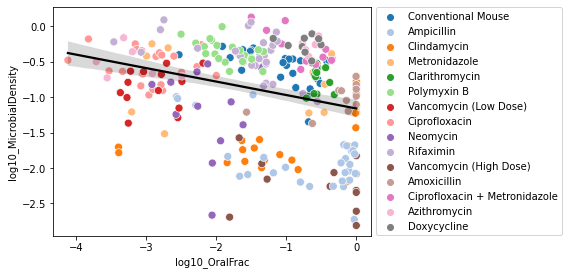

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

df2_meta_oral = df_meta_oral#[df_meta_oral.condition_at_sampling.isin(['Clindamycin','Neomycin','Vancomycin (High Dose)','Ampicillin','Ciprofloxacin','Vancomycin (Low Dose)'])]
_ = sns.scatterplot(x="log10_OralFrac", y="log10_MicrobialDensity", data=df2_meta_oral, hue='condition_at_sampling', palette='tab20', s=64, ax=ax)
_ = sns.regplot(x="log10_OralFrac", y="log10_MicrobialDensity", data=df2_meta_oral, scatter=False, color='k', ax=ax)
slope, intercept, r_value, p_value, std_err = stats.linregress(df2_meta_oral['log10_OralFrac'], df2_meta_oral['log10_MicrobialDensity'])
print('all data, n = %d, slope = %2.2f, r = %2.2f, P = %2.6f'%(len(df2_meta_oral), slope, r_value, p_value))
#_ = ax.set_xlim([-4.25, -0.25])
#_ = ax.set_ylim([-2.5, 0.0])
_ =ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Contijoch_oral_vs_load_w_abx.svg", dpi=600)